# Simulation Run Log Analysis and Visualization for AWS DeepRacer

Use this notebook to analyze DeepRacer **training logs** and **evaluation logs**. It can also simulate the car's on-track behavior by feeding track images to the model, which allows you to see what parts of the track environment the model is "focusing" on when choosing an action.

The code here borrows heavily from the [DeepRacer community log analysis code](https://github.com/aws-deepracer-community/deepracer-analysis) and also the [AWS DeepRacer 400L workshop](https://catalog.us-east-1.prod.workshops.aws/workshops/66473261-de66-42a1-b280-3e0ec87aee26/en-US/account-access).

This code should work for both training and evaluation logs, for both types of actino space (discrete and continuous).

# Prerequisites

Run the cells in this section to make sure all required libraries and tools are installed, before running the rest of the code in the notebook.

**Warning**: If the "Model Performance" code at the end of the notebook fails to run, you may need to install additional dependencies for OpenCV. On ubuntu, you can do this with:

```
sudo apt-get install libgl1-mesa-dev
```

If the code still fails to run, install additional dependencies for OpenCV with:

```
sudo apt-get install build-essential cmake git pkg-config libgtk-3-dev libavcodec-dev libavformat-dev libswscale-dev libv4l-dev libxvidcore-dev libx264-dev libjpeg-dev libpng-dev libtiff-dev gfortran openexr libatlas-base-dev python3-dev python3-numpy libtbb2 libtbb-dev libdc1394-22-dev
```

Then reinstall OpenCV with:

```
pip install opencv-python
```

## Configuring IAM Permissions (Optional)

If you plan to automatically fetch log data using the DeepRacer API, this notebook will need to have permissions to access the DeepRacer services, and possibly additional services like S3. 

- If you are using your local machine, make sure you have the AWS CLI installed and have a valid Access Key with the required permissions.
- If you are using SageMaker, make sure you have a SageMaker execution role attached to your Notebook with the required permissions. If you set up SageMaker using the `drlogs.yaml` CloudFormation template from [this github repository](https://github.com/jeremypedersen/deepracer-deepstats/), you should already have the required permissions. 
- If you are using EC2, make sure you have an EC2 instance role attached to your instance and that you have installed the AWS CLI and run `aws configure` to setup a default profile. 

## Install required tools

Run the code below to install required tools and libraries. 

In [1]:
# Upgrade pip + fetch dependencies
!pip install --upgrade pip
!pip install boto3 awscli

# Install shapely (used later to draw the track outline)
!pip install shapely

# Install OpenCV, which is needed later on to generate heatmaps of the track
!pip install opencv-python

# Force an uninstall of numpy followed by installation of tensorflow, which
# should force us to pull a version of numpy that will work with the current
# version of tensorflow
!pip uninstall numpy -y
!pip install tensorflow

# Additional installs (many systems will include these already)
!pip install pandas matplotlib scikit-learn

# Fetch other dependencies
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import boto3
import shutil
import os
import glob
import math
import tarfile
import requests
import json
%matplotlib inline

#Pull in code from Shapely to help us plot the racetrack outline
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

# Pull in tools to work with files
from os import listdir
from os.path import isfile, join

# Import primitives from matplotlib (required by some helper functions)
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl (13.7 MB)


# Helper Functions

This section contains helper functions used to plot and analyze the logs. These functions are hidden by default. 

In [2]:
# Some helpers used during plotting of tracks 
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(inner_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=1)


def plot_bounds(ax, ob):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, '.', color='#000000', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

In [3]:
def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='r', alpha=0.3):

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

    # Plot errorbars
    #artists = ax.errorbar(xdata, ydata, xerr=xerror, yerr=yerror,
    #                      fmt='None', ecolor='k')

    return 0

In [4]:
def episode_parser(df, action_map=True, episode_map=True):
    '''
    Arrange data per episode
    '''
    action_map = {} # Action => [x,y,reward] 
    episode_map = {} # Episode number => [x,y,action,reward] 

    for index, row in df.iterrows():
        e = int(row['episode'])
        x = float(row['x']) 
        y = float(row['y'])
        angle = float(row['steer'])
        ttl = float(row['throttle'])
        action = int(row['action'])
        reward = float(row['reward'])

        try:
            episode_map[e]
        except KeyError:
            episode_map[e] = np.array([0,0,0,0,0,0]) #dummy
        episode_map[e] = np.vstack((episode_map[e], np.array([x,y,action,reward,angle,ttl])))

        try:
            action_map[action]
        except KeyError:
            action_map[action] = []
        action_map[action].append([x, y, reward])
                
    # top laps
    total_rewards = {}
    for x in episode_map.keys():
        arr = episode_map[x]
        total_rewards[x] = np.sum(arr[:,3])

    import operator
    top_idx = dict(sorted(total_rewards.items(), key=operator.itemgetter(1), reverse=True)[:])
    sorted_idx = list(top_idx.keys())

    return action_map, episode_map, sorted_idx

In [5]:
# Plot the track
def plot_track(df, track_size=(8,8), x_offset=0, y_offset=0, scale=100):
    allx=[]
    ally=[]
    allreward=[]
    for index, row in df.iterrows():
        x = float(row["x"]) + x_offset
        y = float(row["y"]) + y_offset
        reward = float(row["reward"])
        allx.append(x) # May need to include offsets here to center the plot
        ally.append(y) # May need to include offsets here to center the plot
        allrewards=reward
    heatmap, xedges, yedges = np.histogram2d(allx, ally, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    # Set the extent to use the minimum and maximum (X,Y) values of the track,
    # plus a small padding value
    outer_x = [i[0] for i in outer_border]
    outer_y = [i[1] for i in outer_border]
    extent = [min(outer_x), max(outer_x), min(outer_y), max(outer_y)]
        
    fig = plt.figure(1, figsize=track_size)
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return heatmap.T,extent

In [6]:
# Plot the top N laps (5 by default)
def plot_top_laps(sorted_idx, n_laps=5, track_size=(8,8)):
    fig = plt.figure(n_laps, figsize=track_size) 
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1, car_x2], [y1, car_y2], 'b.')
        
    return fig

# Fetch Logs and (Optionally) DeepRacer Model Checkpoint

**Pay special attention to the cell below**. This is where you will specify the path to your log files and model files and/or specify that you would like to fetch this data from the DeepRacer console using the API. 

There are several different ways to fetch your model 

In [7]:
# Adjust the parameters below based on whether you are downloading models from AWS DeepRacer or 
# analyzing local files.
# WARNING: Make sure all parameters are set correctly, or parts of the notebook may fail to run! 

# #
# # Download from AWS, training, discrete
# #
# download_from_aws = True
# is_training = True
# model_name="reinvent-2018-discrete-ppo-v1" ## Name of your model in the DeepRacer console

# #
# # Download from AWS, evaluation, discrete
# #
# download_from_aws = True
# is_training = False
# model_name="reinvent-2018-discrete-ppo-v1" ## Name of your model in the DeepRacer console

# #
# # Download from AWS, training, continuous
# #
# download_from_aws = True
# is_training = True
# model_name="reinvent-2018-continuous-ppo-v1" ## Name of your model in the DeepRacer console

# #
# # Download from AWS, evaluation, continuous
# #
# download_from_aws = True
# is_training = False
# model_name="reinvent-2018-continuous-ppo-v1" ## Name of your model in the DeepRacer console

#
# Local, training, discrete
#
# download_from_aws = False
# is_training = True
# log_path="./local_model_files/reinvent-2018-discrete-ppo-v1-training-logs.tar.gz" # Path to log files
# model_path="./local_model_files/reinvent-2018-discrete-ppo-v1-model.tar.gz" # Path to model file (needed for Tensorflow model analysis at the end of the notebook)

# #
# # Local, evaluation, discrete
# #
# download_from_aws = False
# is_training = False
# log_path="./local_model_files/reinvent-2018-discrete-ppo-v1-evaluation-logs.tar.gz"
# model_path="./local_model_files/reinvent-2018-discrete-ppo-v1-model.tar.gz" # Path to model file (needed for Tensorflow model analysis at the end of the notebook)


# #
# # Local, training, continuous
# #
# download_from_aws = False
# is_training = True
# log_path="./local_model_files/reinvent-2018-continuous-ppo-v1-training-logs.tar.gz" # Path to log files
# model_path="./local_model_files/reinvent-2018-continuous-ppo-v1-model.tar.gz" # Path to model file (needed for Tensorflow model analysis at the end of the notebook)


# #
# # Local, evaluation, continuous
# #
# download_from_aws = False
# is_training = False
# log_path="./local_model_files/reinvent-2018-continuous-ppo-v1-evaluation-logs.tar.gz" # Path to log files
# model_path="./local_model_files/reinvent-2018-continuous-ppo-v1-model.tar.gz" # Path to model file (needed for Tensorflow model analysis at the end of the notebook)

# #
# # Local, training, continuous (2019 track)
# #
download_from_aws = False
is_training = True
log_path="./local_model_files/reInvent2019-continuous-training-logs.tar.gz" # Path to log files
model_path="./local_model_files/reinvent2019-continuous-model.tar.gz" # Path to model file (needed for Tensorflow model analysis at the end of the notebook)

# # #
# # # Local, evaluation, continuous (2019 track)
# # #
# download_from_aws = False
# is_training = False
# log_path="./local_model_files/reInvent2019-continuous-evaluation-logs.tar.gz" # Path to log files
# model_path="./local_model_files/reinvent2019-continuous-model.tar.gz" # Path to model file (needed for Tensorflow model analysis at the end of the notebook)

# # #
# # # Local, training, continuous (Vivalas loop)
# # #
# download_from_aws = False
# is_training = True
# log_path="./local_model_files/vivalas-loop-v1-training-logs.tar.gz" # Path to log files
# model_path="./local_model_files/vivalas-loop-v1-model.tar.gz" # Path to model file (needed for Tensorflow model analysis at the end of the notebook)

# # #
# # # Local, evaluation, continuous (Vivalas loop)
# # #
# download_from_aws = False
# is_training = False
# log_path="./local_model_files/vivalas-loop-v1-evaluation-logs.tar.gz" # Path to log files
# model_path="./local_model_files/vivalas-loop-v1-model.tar.gz" # Path to model file (needed for Tensorflow model analysis at the end of the notebook)



In [8]:
# Remove any tempfiles from previous analyses
!rm -rf ./tmp
!rm -rf ./intermediate_checkpoint
!rm -rf ./downloaded_model
!rm -rf ./local_model_files/tmp

# Clean up any lingering .tar.gz files downloaded previously
!rm -rf *.tar.gz 

zsh:1: no matches found: *.tar.gz


In [9]:
# Code below will fetch logs and model files directly from AWS using the API,
# if download_from_aws was set to true above
if download_from_aws: 

    #
    # Fetch model ARN
    #
    
    # Add the DeepRacer API spec (in the 'models' folder) to the environment
    envroot = os.getcwd()
    aws_data_path = set(os.environ.get('AWS_DATA_PATH', '').split(os.pathsep))
    aws_data_path.add(os.path.join(envroot, 'models'))
    os.environ.update({'AWS_DATA_PATH': os.pathsep.join(aws_data_path)})

    region = "us-east-1"
    dr_client = boto3.client('deepracer', region_name=region,
            endpoint_url="https://deepracer-prod.{}.amazonaws.com".format(region))
    models = dr_client.list_models(ModelType="REINFORCEMENT_LEARNING",MaxResults=100)["Models"]
    for model in models:
        if model["ModelName"]==model_name:
            break
    ModelArn=model["ModelArn"]
    
    #
    # Pull in training (or evaluation) logs 
    #
    
    print('Downloading logs...')
    
    # Sanity check: move to the correct directory first
    !cd {envroot}
    
    # Note: loads first matching training job only
    if is_training:
        training_job=dr_client.list_training_jobs(ModelArn=ModelArn,MaxResults=100)["TrainingJobs"][0]
        training_log_url= dr_client.get_asset_url(Arn=training_job['JobArn'], AssetType="LOGS")['Url']

        with requests.get(training_log_url, stream=True) as response:
            with open("{}.tar.gz".format(model_name), "wb") as tarball:
                for chunk in response.iter_content(16384):
                    tarball.write(chunk)
    
    # Note: loads first matching evaluation job only
    else:       
        evaluation_job = dr_client.list_evaluations(ModelArn=ModelArn,MaxResults=100)["EvaluationJobs"][0]
        evaluation_log_url= dr_client.get_asset_url(Arn=evaluation_job['JobArn'], AssetType="LOGS")['Url']

        with requests.get(evaluation_log_url, stream=True) as response:
            with open("{}.tar.gz".format(model_name), "wb") as tarball:
                for chunk in response.iter_content(16384):
                    tarball.write(chunk)

    #
    # Unpack logs (locate 'simtrace' data)
    #
    
    ModelUuid=ModelArn[ModelArn.rfind('/')+1:]

    # The path to the simtrace will differ based on whether the logs are training logs or evaluation logs
    if is_training:
        simtrace_path = "./downloaded_model/{}/sim-trace/training/training-simtrace/".format(ModelUuid)
    else:
        simtrace_path = "./downloaded_model/{}/sim-trace/evaluation/*/evaluation-simtrace/".format(ModelUuid)
    merged_simtrace_path = "./logs/deepracer-{}.csv".format(model_name)

    # Create local directories to store the logs
    !mkdir -p downloaded_model/{ModelUuid}
    !mkdir -p intermediate_checkpoint/{ModelUuid}/model-artifacts

    # Unpack the logs (compressed tarball)
    !tar -xf {model_name}.tar.gz -C ./downloaded_model/
    !mkdir -p ./tmp
    
    # Sanity check
    print(f'Simtrace path: {simtrace_path}')
    
    !rsync -a --delete {simtrace_path} ./tmp/
    !rm -rf downloaded_model/{model_name}
    
    #
    # Download physical car model (for Tensorflow heatmap analysis at the end
    # of this notebook)
    # 
    print('Downloading physical car model...')
    
    model_url=dr_client.get_asset_url(Arn=model["ModelArn"],AssetType="COMPLETE_MODEL_ARTIFACT")['Url']

    with requests.get(model_url, stream=True) as response:
        with open("{}-model.tar.gz".format(model_name), "wb") as tarball:
            for chunk in response.iter_content(16384):
                tarball.write(chunk)

    # Unpack the model (also stored as a compressed tarball)
    !tar zxvf {model_name}-model.tar.gz -C intermediate_checkpoint/
    
    #
    # Fetch model 'artifacts' 
    #
    print('Downloading model artifacts...')
    
    # Artifacts include: 
    # 'model_metadata.json' file, which contains:
    # - Action space settings for the model
    # - Training algorithm (PPO or SAC)
    # - Neural network configuration
    # - Sensor configuration
    model_url=dr_client.get_asset_url(Arn=model["ModelArn"], AssetType="MODEL_ARTIFACT")['Url']

    with requests.get(model_url, stream=True) as response:
        with open("{}-model-artifacts.tar.gz".format(model_name), "wb") as tarball:
            for chunk in response.iter_content(16384):
                tarball.write(chunk)

    !tar zxvf {model_name}-model-artifacts.tar.gz -C intermediate_checkpoint/{ModelUuid}/model-artifacts    

In [10]:
# NOTE! The code below expects you to unpack the model 
if not download_from_aws:
    #
    # Unpack logs (locate 'simtrace' data)
    #
    
    # Set up log and tmp directories, if they don't already exist
    !mkdir -p ./logs
    !mkdir -p ./tmp
    
    # Set up local temp directory for unpacking simtrace data
    !rm -rf ./local_model_files/tmp
    !mkdir ./local_model_files/tmp
    !tar zxvf {log_path} -C ./local_model_files/tmp/
    !cp -r ./local_model_files/*/* ./tmp/
    
    if is_training:
        simtrace_path = "./local_model_files/tmp/*/sim-trace/training/training-simtrace/"
    else:
        simtrace_path = "./local_model_files/tmp/*/sim-trace/evaluation/*/evaluation-simtrace/"
    
    !cp -r {simtrace_path} "./tmp/"
    
    # Will need this later when we glob the simtrace files together
    merged_simtrace_path = "./logs/deepracer-local.csv"
    
    #
    # Unpack model and model artifacts
    #
    ModelUuid = 'deepracer-local'
    
    !mkdir -p ./intermediate_checkpoint/{ModelUuid}/model-artifacts
    !tar zxvf {model_path} -C intermediate_checkpoint/{ModelUuid}/model-artifacts

x e5aed8ad-ece1-4fee-a6e6-cd4a9158743a/logs/training/training-20240508075143-RhEr-u1VR9W-U8w-JHkHyQ-sagemaker.log
x e5aed8ad-ece1-4fee-a6e6-cd4a9158743a/logs/training/training-20240508075144-RhEr-u1VR9W-U8w-JHkHyQ-robomaker.log
x e5aed8ad-ece1-4fee-a6e6-cd4a9158743a/metrics/training/training-20240508064543-RhEr-u1VR9W-U8w-JHkHyQ.json
x e5aed8ad-ece1-4fee-a6e6-cd4a9158743a/sim-trace/training/training-simtrace/0-iteration.csv
x e5aed8ad-ece1-4fee-a6e6-cd4a9158743a/sim-trace/training/training-simtrace/1-iteration.csv
x e5aed8ad-ece1-4fee-a6e6-cd4a9158743a/sim-trace/training/training-simtrace/2-iteration.csv
x e5aed8ad-ece1-4fee-a6e6-cd4a9158743a/sim-trace/training/training-simtrace/3-iteration.csv
x e5aed8ad-ece1-4fee-a6e6-cd4a9158743a/sim-trace/training/training-simtrace/4-iteration.csv
x e5aed8ad-ece1-4fee-a6e6-cd4a9158743a/sim-trace/training/training-simtrace/5-iteration.csv
x e5aed8ad-ece1-4fee-a6e6-cd4a9158743a/sim-trace/training/training-simtrace/6-iteration.csv
x e5aed8ad-ece1-4fee

In [11]:
# Parse the 'model_metadata.json' file and read sensor data
# to determine whether LIDAR is present and how many cameras
# are in use (1 or 2)
with open("intermediate_checkpoint/{}/model-artifacts/model_metadata.json".format(ModelUuid),"r") as jsonin:
    model_metadata=json.load(jsonin)

sensor = [sensor for sensor in model_metadata['sensor'] if sensor != "LIDAR"][0]

# Sanity check: print the model metadata so we can inspect it
model_metadata

{'action_space': {'steering_angle': {'high': 30.0, 'low': -30.0},
  'speed': {'high': 1.5, 'low': 1.0}},
 'sensor': ['FRONT_FACING_CAMERA'],
 'neural_network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'version': '5',
 'training_algorithm': 'clipped_ppo',
 'action_space_type': 'continuous',
 'preprocess_type': 'GREY_SCALE',
 'regional_parameters': [0, 0, 0, 0]}

### Combine all the simtrace `.csv` files into a single file

In [12]:
# Create logs folder, if it doesn't already exist
!mkdir -p logs

def get_sort_csv_file():
    sim_trace_csvs = glob.glob("./tmp/*.csv")
    csvs_with_ids = [(int(os.path.basename(file).split("-")[0]), file) for file in sim_trace_csvs]
    csvs_sorted = sorted(csvs_with_ids, key=lambda csvs_with_ids: csvs_with_ids[0])
    return [csv_file[1] for csv_file in csvs_sorted]
    
def merge_csv_files(output_file_path):
    csv_files = get_sort_csv_file()
    header_saved = False
    with open(output_file_path, 'w') as fout:
        for csv_file in csv_files:
            with open(csv_file) as fin:
                header = next(fin)
                if not header_saved:
                    fout.write(header)
                    header_saved = True
                for line in fin:
                    line = re.sub(r'(\[[^\]]*\])', r'"\1"', line, flags=re.M)
                    fout.write(line)

merge_csv_files(merged_simtrace_path)
!tail -n 3 $merged_simtrace_path # Check that merged CSV file result looks OK

179,278.0,-3.369439244218518,0.8605606384614065,-144.92897331278343,30.0,1.0,"[30.0 1.0]",0.5,False,True,99.73250520745886,74,23.090893150458665,1890.701,in_progress,0.0
179,279.0,-3.4085359947661757,0.8145423481810342,-141.29444954048944,-4.977410502467109,1.2978415637393663,"[-4.977410502467109 1.2978415637393663]",0.5,False,True,99.9708647598555,74,23.090893150458665,1890.769,in_progress,0.0
179,280.0,-3.4619521466084815,0.7563074155905127,-138.6488764897042,4.927139830201128,1.2572509389328441,"[4.927139830201128 1.2572509389328441]",0.5,True,True,100,74,23.090893150458665,1890.836,lap_complete,0.0


## Load Track Data (Waypoints)

In [13]:
if download_from_aws:
    if is_training:
        track_arn=training_job["Config"]["TrackConfig"]["TrackArn"]
    else:
        track_arn=evaluation_job["Config"]["TrackArn"]

    # Pull the track name from the logs
    trackname=track_arn[track_arn.rfind("/")+1:]
else:
    # Locate the raw training logs and fetch the world name
    if is_training:
        !grep "World name passed in YAML:" ./local_model_files/tmp/*/logs/*/*-robomaker.log | awk -F': ' '{gsub(/^ *| *$/,"", $2); print $2}' > ./tmp/trackname.txt
        !grep "Updating world name based on track direction YAML parameter:" ./local_model_files/tmp/*/logs/*/*-robomaker.log | awk -F': ' '{gsub(/^ *| *$/,"", $2); print $2}' > ./tmp/trackname_fallback.txt
    else:
        !grep "World name passed in YAML:" ./local_model_files/tmp/*/logs/*/*-sagemaker.log | awk -F': ' '{print $2}' > ./tmp/trackname.txt
        !grep "Updating world name based on track direction YAML parameter:" ./local_model_files/tmp/*/logs/*/*-sagemaker.log | awk -F': ' '{gsub(/^ *| *$/,"", $2); print $2}' > ./tmp/trackname_fallback.txt
    
    # Read the track name
    with open('./tmp/trackname.txt') as f:
        trackname = f.read().strip()

    # Re-read track name (see if we need to update it, as is the case with directional tracks)
    with open('./tmp/trackname_fallback.txt') as f:
        trackname_fallback = f.read().strip()

    if trackname_fallback.strip() != '':
        trackname = trackname_fallback

print(f'Track used for training/evaluation was: {trackname}')

# For tracks which only have a single race direction, 
waypoints = np.load("tracks/%s.npy" % trackname)
waypoints.shape

Track used for training/evaluation was: reInvent2019_track_ccw


(79, 6)

## Visualize the Track and Waypoints

In [14]:
# Set the track size to be used to guide the aspect ratio of the plots
# below
track_dims = (12,12) # Default to 12x12 inches square

In [15]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

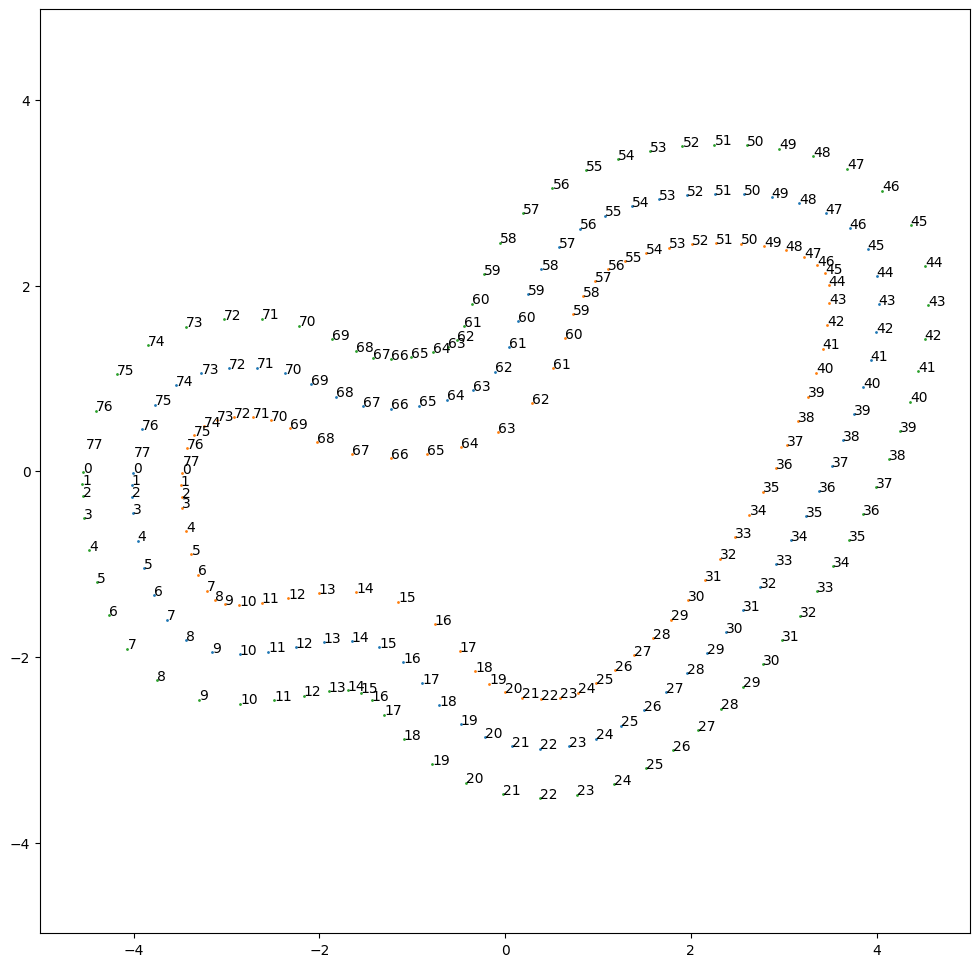

In [16]:
# Plot the results (center, inner, and outer waypoints)
fig, ax = plt.subplots(figsize=track_dims)
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

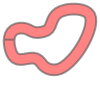

In [17]:
# Use Shapely to generate lines for the inner 
# and outer track borders, and centerline
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])

# Create a shapely Polygon representing the track
road_poly = Polygon(np.vstack((l_outer_border.coords, np.flipud(l_inner_border.coords))))
road_poly

In [18]:
# Load waypoints (we will need these later to construct plots of the track)
center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

# Load Training Logs

In [19]:
EPISODE_PER_ITER = 20 if is_training else 1

In [20]:
# Create a Numpy array with raw data from each episode, including
# the (x,y) position of the car, yaw, steering angle, 
# throttle position, action, and reward
print(merged_simtrace_path)
df = pd.read_csv(merged_simtrace_path)
iteration_arr = np.arange(math.ceil(df.episode.max()/EPISODE_PER_ITER)+1) * EPISODE_PER_ITER
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
df.head() # NOTE: We list only the first few rows, as the table can be thousands of rows long

./logs/deepracer-local.csv


,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,pause_duration,iteration
0,0,1.0,-4.022866,-0.154528,-95.001899,-30.000000,1.000000,[-30.0 1.0],0.0,False,True,0.606489,1,23.090893,6.937,prepare,0.0,1
1,0,2.0,-4.022849,-0.154372,-95.001228,-8.696522,1.128679,[-8.696522112975128 1.1286793237186612],1.0,False,True,0.605818,1,23.090893,7.006,in_progress,0.0,1
2,0,3.0,-4.023938,-0.165413,-95.049103,3.970782,1.355689,[3.970782202766827 1.3556885887327732],1.0,False,True,0.653249,1,23.090893,7.073,in_progress,0.0,1
3,0,4.0,-4.025978,-0.189770,-95.044687,30.000000,1.128026,[30.0 1.1280263031727424],1.0,False,True,0.757984,1,23.090893,7.133,in_progress,0.0,1
4,0,5.0,-4.022066,-0.223859,-93.371611,-30.000000,1.000000,[-30.0 1.0],1.0,False,True,0.906381,2,23.090893,7.201,in_progress,0.0,1


If the model used a continuous action space, we need to convert to a discrete action space by bucketing the actions into a discrete set. This will make it easier for us to generalize about the actions being taken by the car (i.e. are certain steering and throttle positions more commonly used? Are any portions of the action space being ignored?)

In [21]:
# NOTE: The purpose of the code below is to map continuous action space models
# into an imaginary discrete action space, to make analyzing the car's choices
# a little simpler (we can plot graphs for specific speed/action pairs and see
# how "often" the car chose them

# Change these values to generate a more "fine grained" analysis
# HINT: To simply analyze the car's steering decisions (left, right, straight)
# set NUM_ANGLE_BUCKETS to 3 and NUM_SPEED_BUCKETS to 1
NUM_ANGLE_BUCKETS = 3
NUM_SPEED_BUCKETS = 1

# Determine the "action index" in our discrete space which maps most
# closely onto a given continuous [steering_angle, speed] pair
def find_closest_action_index(steering, speed, actions):
    # HINT: We have computed a "symmetric" discrete action space,
    # so there will always be the same set of speed choices for a given
    # steering setting. Therefore, we can break the search in two:
    # 1 - find closest steering angle setting
    # 2 - find closest speed setting for that angle
    
    # Identify closest steering angle
    current_best_index = 0
    current_best_steering = actions[0][1] # Choose steering angle for action "0" as a default
    current_best_speed = actions[0][2] # Choose speed for action "0" as a default
    for i in range(0,len(actions)):
        if abs(steering - actions[i][1]) < abs(steering - current_best_steering):
            current_best_steering = actions[i][1] # Set steering angle
            current_best_index = actions[i][0] # Set index

    # Identify closest speed (starting from previous best index)
    for i in range(current_best_index, len(actions)):
        if abs(speed - actions[i][2]) < abs(speed - current_best_speed):
            current_best_speed = actions[i][2] # Set speed
            current_best_index = actions[i][0] # Set index

    # Rreturn cloest index
    return current_best_index        

# Import pprint to nicely print the updated
# action space
from pprint import pprint
from math import floor

# Re-load model metadata
if download_from_aws:
    with open("intermediate_checkpoint/{}/model/model_metadata.json".format(ModelUuid),"r") as jsonin:
        model_metadata=json.load(jsonin)
else:
    with open("intermediate_checkpoint/deepracer-local/model-artifacts/model_metadata.json".format(ModelUuid),"r") as jsonin:
        model_metadata=json.load(jsonin)

if 'action_space_type' in model_metadata and model_metadata['action_space_type']=='continuous':
    max_angle = model_metadata['action_space']['steering_angle']['high']
    min_angle = model_metadata['action_space']['steering_angle']['low']

    max_speed = model_metadata['action_space']['speed']['high']
    min_speed = model_metadata['action_space']['speed']['low']

    # DEBUG: Print min and max values (sanity check)
    print(f'\n{'='*5} Speed and steering ranges {'='*5}\n')
    print(f'Min speed: {min_speed}')
    print(f'Max speed: {max_speed}')
    print(f'Max left (steering): {max_angle}')
    print(f'Max right (steering): {min_angle}\n')

    # Pre-compute discrete steering angles (and speeds) that we can
    # map onto our continuous action space
    angle_step = (max_angle - min_angle) / NUM_ANGLE_BUCKETS
    starting_angle = min_angle + angle_step/2

    speed_step = (max_speed - min_speed) / NUM_SPEED_BUCKETS
    starting_speed = min_speed + speed_step/2
    
    new_actions = [] # A list of [index, steering_angle, speed] pairs

    index = 0
    for i in range(0, NUM_ANGLE_BUCKETS):
        
        speed = starting_speed # Reset starting speed
        for i in range(0, NUM_SPEED_BUCKETS):
            new_actions.append([index, round(starting_angle,1), round(speed,1)])
            speed += speed_step
            index += 1 # Increment the index

        starting_angle += angle_step

    print(f'{'='*5} Computed action space {'='*5}\n')
    print(f'Total actions: {len(new_actions)}, Total expected actions: {NUM_ANGLE_BUCKETS * NUM_SPEED_BUCKETS}')
    pprint(new_actions)

    # Pre-compute discrete steering angles
    steering_step = round((max_angle - min_angle) / NUM_ANGLE_BUCKETS, 1) 

    # Update our actions (mapped into the new discrete action space)
    for index, row in df.iterrows(): 
        closest_index = find_closest_action_index(row["steer"], row["throttle"], new_actions)
        df.at[index,"action"] = closest_index
    
    model_metadata['action_space'] = [] # Clear action space
    for index, steering, speed in new_actions:
        model_metadata['action_space'].append({'index':index, 'speed': speed,'steering_angle': steering})

    # Check results
    print(f'\n{'='*5} Sample data (with updated actions) {'='*5}\n')
    print(df.head())

    # Check if action_space has been effectively binned
    print(f'\n{'='*5} Updated action space {'='*5}\n')
    pprint(model_metadata['action_space'])


===== Speed and steering ranges =====

Min speed: 1.0
Max speed: 1.5
Max left (steering): 30.0
Max right (steering): -30.0

===== Computed action space =====

Total actions: 3, Total expected actions: 3
[[0, -20.0, 1.2], [1, 0.0, 1.2], [2, 20.0, 1.2]]

===== Sample data (with updated actions) =====

   episode  steps         x         y        yaw      steer  throttle action  \
0        0    1.0 -4.022866 -0.154528 -95.001899 -30.000000  1.000000      0   
1        0    2.0 -4.022849 -0.154372 -95.001228  -8.696522  1.128679      1   
2        0    3.0 -4.023938 -0.165413 -95.049103   3.970782  1.355689      1   
3        0    4.0 -4.025978 -0.189770 -95.044687  30.000000  1.128026      2   
4        0    5.0 -4.022066 -0.223859 -93.371611 -30.000000  1.000000      0   

   reward   done  all_wheels_on_track  progress  closest_waypoint  track_len  \
0     0.0  False                 True  0.606489                 1  23.090893   
1     1.0  False                 True  0.605818          

In [22]:
# Normalize the rewards to a 0-1 scale for easier plotting
from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())

## Plot the Rewards Earned Per Iteration

This graph is useful to understand the mean reward and standard deviation within each episode 

Number of episodes =  179
Minimum mean reward: 14.0351
Maximum mean reward: 163.69234999999998


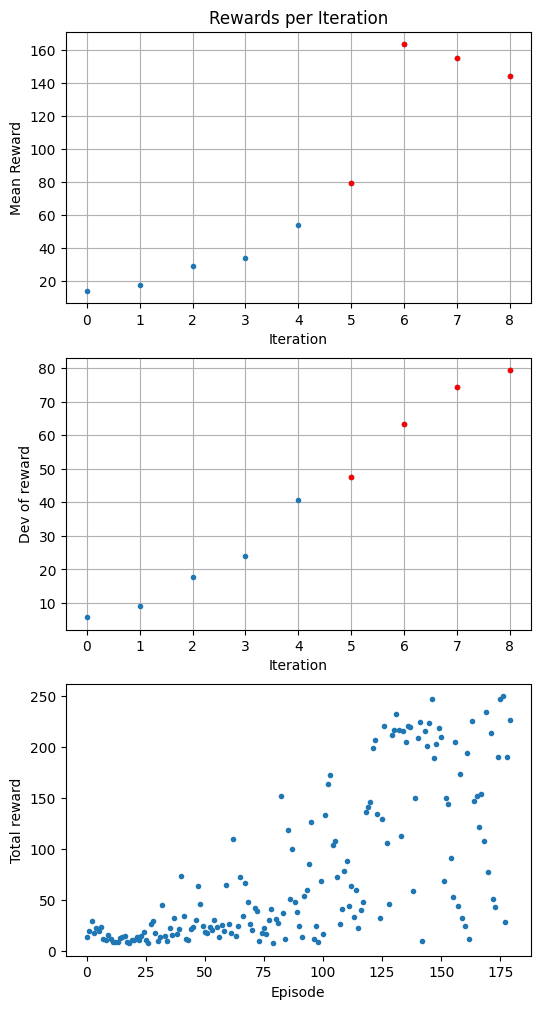

In [23]:
# This value adjusts the color used to plot mean reward
# rewards above this threshold value are plotted in RED
# while rewards below this threshold are plotted in BLUE

# WARNING: We are summing rewards here so values will be higher than 1, 
# despite the normalization performed above. You will need to tweak this value.
REWARD_THRESHOLD = 70

# Reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
    
for epi in np.arange(min_episodes, max_episodes+1,1):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == EPISODE_PER_ITER:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()

# Plot mean reward per iteration
fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean Reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

# Plot standard deviation of rewards per iteration
ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')

# Plot total reward per episode
ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

# Comment these two print statements in, to get an idea how to set your
# REWARD_THRESHOLD value
print('Minimum mean reward: {}'.format(min(average_reward_per_iteration)))
print('Maximum mean reward: {}'.format(max(average_reward_per_iteration)))

## Analyze training/evaluation metrics with progress and reward function

This graph gives you an idea whether your model has convergered or more training is required. If you see the curve trending upwards then more training time would help the agent to get better rewards

In [24]:
if download_from_aws:
    if is_training:
        METRIC_PATH = glob.glob("./intermediate_checkpoint/{}/metrics/training/*.json".format(ModelUuid))[0]
    else:
        METRIC_PATH = glob.glob("./intermediate_checkpoint/{}/metrics/evaluation/*.json".format(ModelUuid))[0]
else:
    if is_training:
        METRIC_PATH = glob.glob("./local_model_files/tmp/*/metrics/training/*.json")[0]
    else:
        METRIC_PATH = glob.glob("./local_model_files/tmp/*/metrics/evaluation/*.json")[0]
        
with open(METRIC_PATH, "r") as fp:
    data = json.loads(fp.read())
    metric_data = data['metrics']
    df_metrics = pd.DataFrame(metric_data)

if is_training:
    df_metrics = df_metrics[df_metrics['phase'] == "training"]

# Print a few rows from df_metrics, so we can see how the data is formatted
df_metrics

,reward_score,metric_time,start_time,elapsed_time_in_milliseconds,episode,trial,phase,completion_percentage,episode_status
0,14,8998,6875,2123,1,1,training,8,Off track
1,20,11204,9060,2144,2,2,training,8,Off track
2,29,16273,11267,5006,3,3,training,26,Off track
3,17,18471,16340,2131,4,4,training,8,Off track
4,22,20807,18541,2266,5,5,training,8,Off track
...,...,...,...,...,...,...,...,...,...
215,247,1830916,1811767,19149,176,16,training,100,Lap complete
216,250,1850363,1830980,19383,177,17,training,100,Lap complete
217,28,1854772,1850433,4339,178,18,training,20,Off track
218,190,1872119,1854832,17287,179,19,training,93,Off track


Mean percentage: 36.6


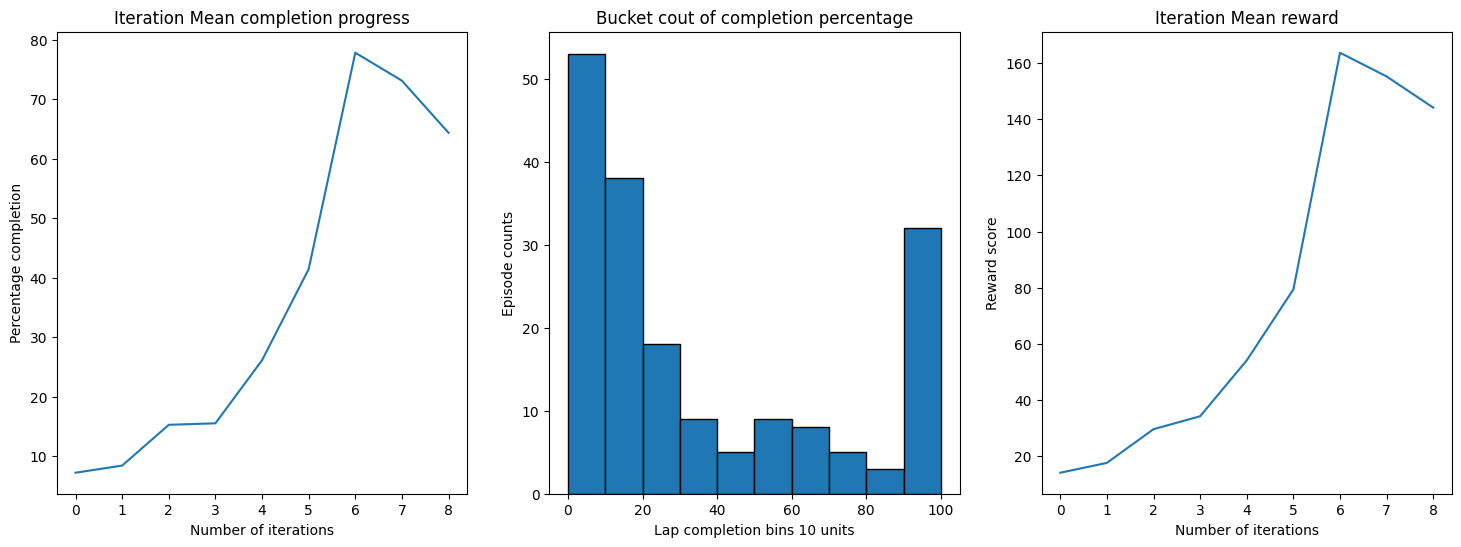

In [25]:
# Bins (for counting up track completion percentage by episode)
bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

df_metrics = df_metrics.sort_values(by="metric_time")
print('Mean percentage: {}'.format(df_metrics.completion_percentage.mean()))

completion_percentage_np = np.array(df_metrics.completion_percentage)
episode_progress_buckets = np.split(completion_percentage_np[:EPISODE_PER_ITER*(len(completion_percentage_np)//EPISODE_PER_ITER)],
                                    len(completion_percentage_np)//EPISODE_PER_ITER)
episode_progress_mean = np.mean(episode_progress_buckets, axis=1)

# Plot mean track completion per iteration
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Line graph showing the mean iteration of completion progress
ax1.plot(episode_progress_mean)
ax1.title.set_text('Iteration Mean completion progress')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Percentage completion')

# Bar chart to show completion_percentage with bucketing of 10% bar chart
ax2.hist(df_metrics.completion_percentage, bins=bins, edgecolor="k")
ax2.title.set_text('Bucket cout of completion percentage')
ax2.set_xlabel('Lap completion bins 10 units')
ax2.set_ylabel('Episode counts')

# Line graph showing the mean iteration of reward mean
if is_training:
    reward_score_np = np.array(df_metrics.reward_score)
    episode_reward_buckets = np.split(reward_score_np[:EPISODE_PER_ITER*(len(reward_score_np)//EPISODE_PER_ITER)],
                                                      len(reward_score_np)//EPISODE_PER_ITER)
    episode_reward_mean = np.mean(episode_reward_buckets, axis=1)
    ax3.plot(episode_reward_mean)
    plt.title("Metric analysis - Reward/percentage vs number of iterations")
    ax3.title.set_text('Iteration Mean reward')
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Reward score')
    plt.show()


## Analyze Reward Function Reward Distribution (Plotted On The Track)

In [26]:
# These values can be useful in determing how much (X,Y) offset is required 
# if the graph appears off-center
print("Min x-axis {}; Max x-axis {}".format(np.min(df['x']), np.max(df['x'])))
print("Min y-axis {}; Max y-axis {}".format(np.min(df['y']), np.max(df['y'])))

Min x-axis -4.805641472146741; Max x-axis 4.839230800707498
Min y-axis -3.690244585933597; Max y-axis 3.74201221935124


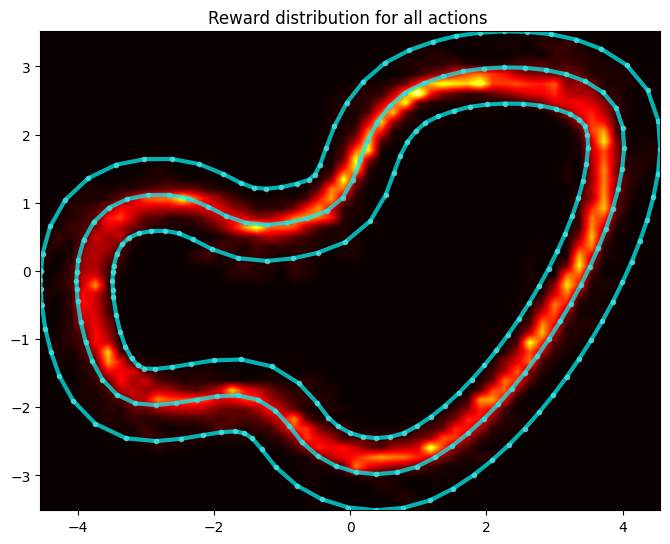

In [27]:
# Plot reward heatmap on top of track outline
# WARNING: This may fail for evaluation jobs, which (for some reason)
# seem to produce car (X,Y) coordinates with an offset
# HINT: You can (sort of) fix this offset using the x_offset and y_offset params below
track,extent = plot_track(df, track_size=(8,8), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Plot A Specific Iteration

Iteration ID range: 1 to 9


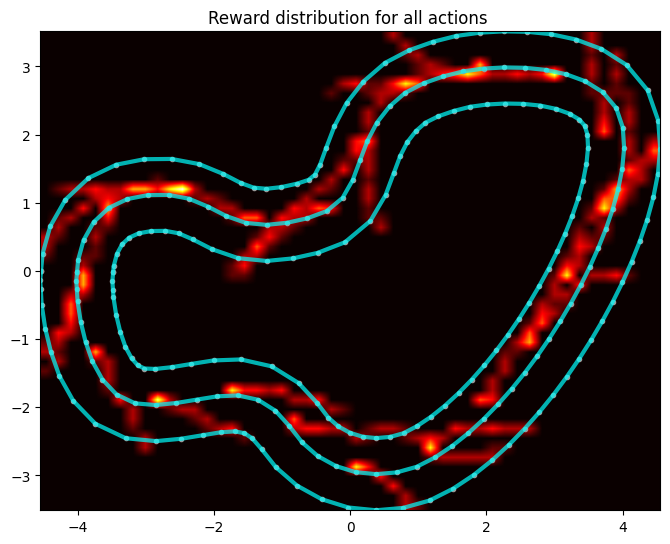

In [28]:
# Print out the minimum and maximum iteration IDs
print('Iteration ID range: 1 to {}'.format(df['iteration'].max()))

iteration_id = 2
track,extent = plot_track(df[df['iteration'] == iteration_id], track_size=(8,8), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Look At The Path Taken During Iterations That Earned A High Reward

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when the car completes 1000 steps

The top 3 highest reward episodes are [176, 146, 175]


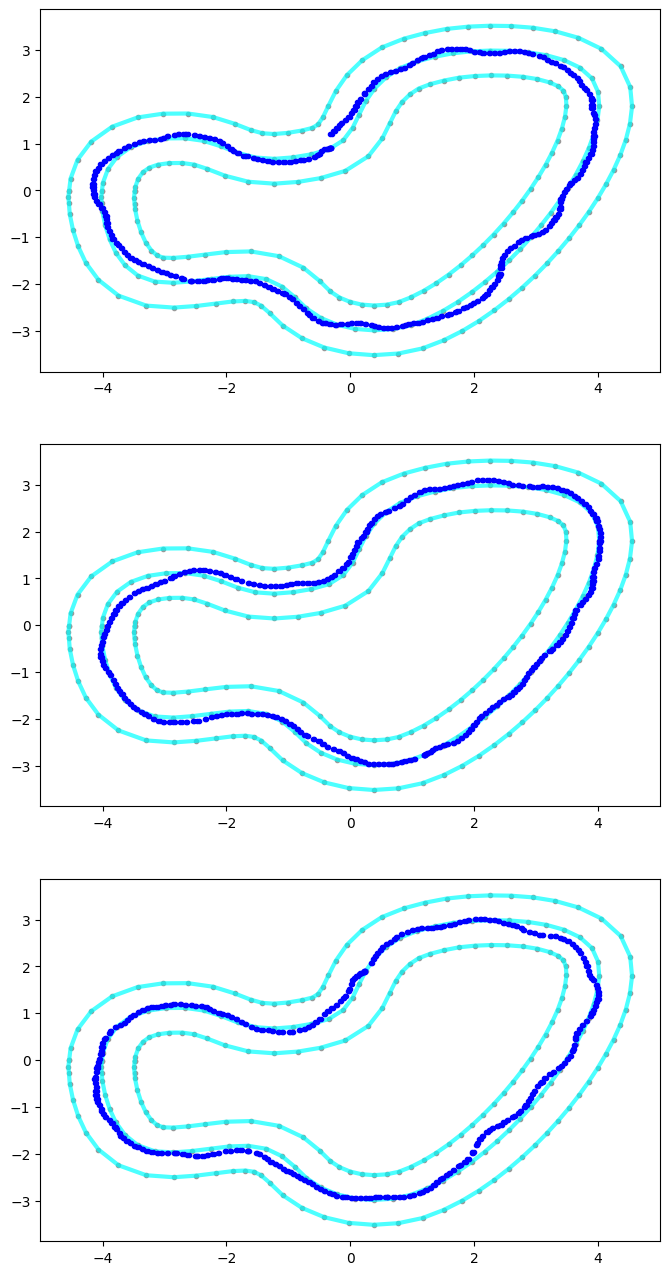

In [29]:
action_map, episode_map, sorted_idx = episode_parser(df)    
fig = plot_top_laps(sorted_idx[:], 3, track_size=(8,16))
print("The top 3 highest reward episodes are {}".format(sorted_idx[:3]))

### Plot The Path Taken In A Particular Episode

In [30]:
def plot_episode_run(df, E, track_size=(8, 8)):
    fig = plt.figure(1, figsize=track_size)
    ax = fig.add_subplot(211)
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

Max episode ID: 179


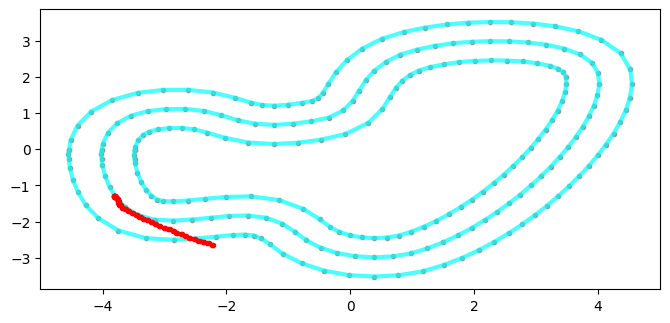

In [31]:
# Print the total number of episodes
print('Max episode ID: {}'.format(df['episode'].max()))

plot_episode_run(df, E=1, track_size=(8,8)) # Choose an arbitrary episode

## Action Breakdown (Per Iteration) With Action Distributoin Histogram

This plot is useful to understand the actions that the model takes for any given iteration.

Say you want the car to go at higher speeds on the straight line. This will give you an idea what actions the car is taking along those segments

In [32]:
# The actions plotted on the tracks may become noise. Use this to clip the low reward values action.
# Anything with reward < 0.8 is clipped. This is based on the reward function you trained on.
REWARD_THRESHOLD = 0.5
    
# Track Segment Labels
action_names = []
for action in model_metadata['action_space']:
    action_names.append("ST"+str(action['steering_angle'])+" SP"+"%.2f"%action["speed"])

print('Number of actions (or action buckets): {}'.format(len(action_names)))
action_names

Number of actions (or action buckets): 3


['ST-20.0 SP1.20', 'ST0.0 SP1.20', 'ST20.0 SP1.20']

**Define track labels**

This hash defines the labels for track segments on various tracks. **Analyzing new tracks will require adding a new entry to this hash.**

In [33]:
track_segments_hash = { "reinvent_base": [(0, 'straightaway'),
                                          (20, 'hairpin'),
                                          (46, 'slight right'),
                                          (61, 'left'),
                                          (76, 'slight left'),
                                          (90, 'straightaway'),
                                          (103, 'left'),
                                          (113, 'straightaway')                                         
                                          ],
                       "reInvent2019_track": [(0, 'left'),
                                              (18, 'sharp right'),
                                              (33, 'gentle left'),
                                              (82, 'left'),
                                              (93, 'slight left'),
                                              (107, 'left'),
                                              (117, 'right'),
                                              (137, 'left')
                                             ],
                       "reInvent2019_track_ccw": [(9, 'left'),
                                              (15, 'sharp right'),
                                              (22, 'gentle left'),
                                              (45, 'left'),
                                              (55, 'slight left'),
                                              (62, 'sharp right'),
                                              (73, 'left')
                                             ],
                       "arctic_open": [(0, 'straightaway'),
                                       (24,'left'),
                                       (36,'right'),
                                       (52,'left'),
                                       (67,'hairpin left'),
                                       (84,'right'),
                                       (98,'slight left'),
                                       (107,'straightaway'),
                                       (125,'slight left'),
                                       (134,'straightaway'),
                                       (156,'hairpin left')            
                       ],
                       "caecer_loop": [(0, 'straightaway'),
                                       (14,'slight left'),
                                       (34,'straightaway'),
                                       (42,'hairpin left'),
                                       (70,'straightaway'),
                                       (80,'sharp left'),
                                       (93,'straightaway'),
                                       (103,'slight left'),
                                       (115,'straightaway')            
                       ],
                       "red_star_open":[(0,'straightaway'),
                                        (29,'left'),
                                        (41,'straightaway'),
                                        (67,'hairpin left'),
                                        (78,'straightaway'),
                                        (94,'s-turn right'),
                                        (107,'s-turn left'),
                                        (119,'s-turn right'),
                                        (130,'s-turn left'),
                                        (140,'straightaway'),
                                        (155,'sharp left'),
                                        (163,'straightaway')                           
                       ]
}
trackname

'reInvent2019_track_ccw'

Number of steps in iteration = 649


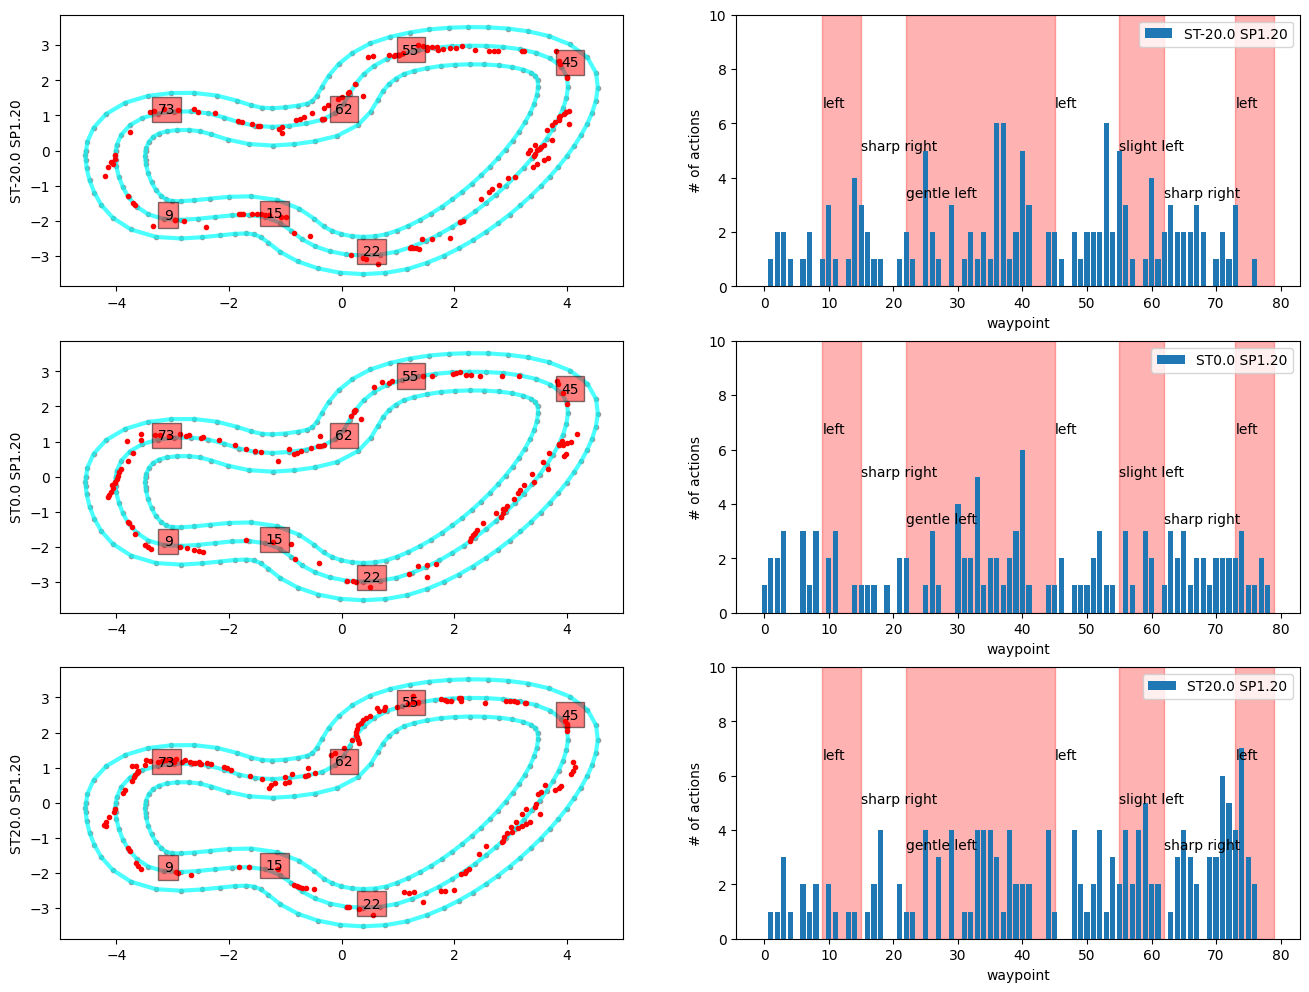

In [34]:
fig = plt.figure(figsize=(16, 4*len(action_names)))

# If this is evaluation, just print the first 3 iterations by default
if is_training:
    iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards
else:
    iterations_downselect = [1,2,3]
    
y_limit = 10
track_segments = track_segments_hash[trackname]
segment_x=[]
segment_y=[]
segment_xerr_l=[]
segment_xerr_r=[]
segment_yerr_n=[]
segment_yerr_s=[]
i=0
while i<len(track_segments):
    segment_x.append(track_segments[i][0])
    segment_y.append(0)
    segment_xerr_l.append(0)
    if i>=len(track_segments)-1:
        segment_xerr_r.append(len(waypoints)-track_segments[i][0])
    else:
        segment_xerr_r.append(track_segments[i+1][0]-track_segments[i][0])
    segment_yerr_n.append(0)
    segment_yerr_s.append(y_limit)
    i+=2

segment_x = np.array(segment_x)
segment_y = np.array(segment_y)
segment_xerr = np.array([segment_xerr_l,segment_xerr_r])
segment_yerr = np.array([segment_yerr_n,segment_yerr_s])

wpts_array = center_line 
text_y=[.66*y_limit,.5*y_limit,.33*y_limit]
    
for iter_num in iterations_downselect:

    # Slice the data frame to get all episodes in that iteration
    df_iter = df[(iter_num == df['iteration'])]
    n_steps_in_iter = len(df_iter)
    print('Number of steps in iteration = {}'.format(n_steps_in_iter))

    # Reward function threshold
    th = REWARD_THRESHOLD
    for idx in range(len(action_names)):

        ax = fig.add_subplot(len(action_names), 2, 2*idx+1)
        print_border(ax, center_line, inner_border, outer_border) 
            
        df_slice = df_iter[df_iter['reward'] >= th]
        df_slice = df_slice[df_slice['action'] == idx]

        ax.plot(df_slice['x'], df_slice['y'], 'r.')

        for idWp in track_segments:
            ax.text(wpts_array[idWp[0]][0], wpts_array[idWp[0]][1], str(idWp[0]), bbox=dict(facecolor='red', alpha=0.5))

        ax.set_ylabel(action_names[idx])

        # calculate action way point distribution
        action_waypoint_distribution = list()
        for idWp in range(len(wpts_array)):
            action_waypoint_distribution.append(len(df_slice[df_slice['closest_waypoint'] == idWp]))

        ax = fig.add_subplot(len(action_names), 2, 2 * idx + 2)

        # Call function to create error boxes
        _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)


        i=0
        for tt in range(len(track_segments)):
            ax.text(track_segments[tt][0], text_y[i], track_segments[tt][1])
            i = (i+1)%len(text_y)

        ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
        ax.set_xlabel('waypoint')
        ax.set_ylabel('# of actions')
        ax.legend([action_names[idx]])
        ax.set_ylim((0, y_limit))

Lets analyze the actions chosen for each situation. Does this model choose to steer or go straight on straightaways? Does it choose to speed up or slow down? Are entire portions of the action space ignored, suggesting a mismatch between the action space at the reward function?

## Simulation Image Analysis - How Confident Is The Model? 

Ideal models will make decisive choices, meaning there should be a large "gap" in the confidence level reported for the first and second best decisions. 

In [35]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

#### Download All Model Checkpoints

You can alter this to focus only on checkpoints you are interested in

In [36]:
# !pip uninstall numpy -y
# !pip install tensorflow

In [37]:
import tensorflow.compat.v1 as tf
from tensorflow.python.platform import gfile
from PIL import Image

tf.disable_v2_behavior()

GRAPH_PB_PATH = 'intermediate_checkpoint/'

def load_session(pb_path):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)
    
    # For front cameras/stereo camera use the below
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

Instructions for updating:
non-resource variables are not supported in the long term


In [38]:
model_inference = []
iterations = [7,8,9]
models_file_path = glob.glob("{}{}/model/model_*.pb".format(GRAPH_PB_PATH, ModelUuid))

for model_file in models_file_path:
    model, obs, model_out = load_session(model_file)
    arr = []
    for f in all_files[:]:
        img = Image.open(f)
        img_arr = np.array(img)
        img_arr = rgb2gray(img_arr)
        img_arr = np.expand_dims(img_arr, axis=2)
        current_state = {"observation": img_arr} #(1, 120, 160, 1)
        y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
        arr.append (y_output)
        
    model_inference.append(arr)
    model.close()
    tf.reset_default_graph()

In [39]:
prob_diff = []

for model, model_file in zip(model_inference, models_file_path):
    print("Inference for model: {}".format(model_file))
    for mi in model:
        max1, max2 = mi.argsort()[-2:][::-1]
        prob_diff.append(mi[max1] - mi[max2])
    plt.hist(prob_diff)
    plt.show()

**Note**: In theory, models which show a large separation between their first and second choice decisions have "high confidence" and should drive more reliably offline.

# Model CSV Analysis


Download the model from the console AWS DeepRacer > Reinforcement learning > **Training Job Name** > Download Model


In [40]:
fname = './intermediate_checkpoint/{}/model-artifacts/worker_0.multi_agent_graph.main_level.main_level.agent_0.csv'.format(ModelUuid)
df_csv = pd.read_csv(fname)

In [41]:
df_csv.columns

Index(['Episode #', 'Training Iter', 'Epoch', 'In Heatup', 'ER #Transitions',
       'ER #Episodes', 'Episode Length', 'Total steps', 'Epsilon',
       'Shaped Training Reward', 'Training Reward', 'Update Target Network',
       'Wall-Clock Time', 'Evaluation Reward', 'Shaped Evaluation Reward',
       'Success Rate', 'Inverse Propensity Score', 'Direct Method Reward',
       'Doubly Robust', 'Weighted Importance Sampling',
       'Sequential Doubly Robust', 'Loss/Mean', 'Loss/Stdev', 'Loss/Max',
       'Loss/Min', 'Learning Rate/Mean', 'Learning Rate/Stdev',
       'Learning Rate/Max', 'Learning Rate/Min', 'Grads (unclipped)/Mean',
       'Grads (unclipped)/Stdev', 'Grads (unclipped)/Max',
       'Grads (unclipped)/Min', 'Discounted Return/Mean',
       'Discounted Return/Stdev', 'Discounted Return/Max',
       'Discounted Return/Min', 'Entropy/Mean', 'Entropy/Stdev', 'Entropy/Max',
       'Entropy/Min', 'Advantages/Mean', 'Advantages/Stdev', 'Advantages/Max',
       'Advantages/Min',

<Axes: title={'center': 'Training'}, xlabel='Training Iter'>

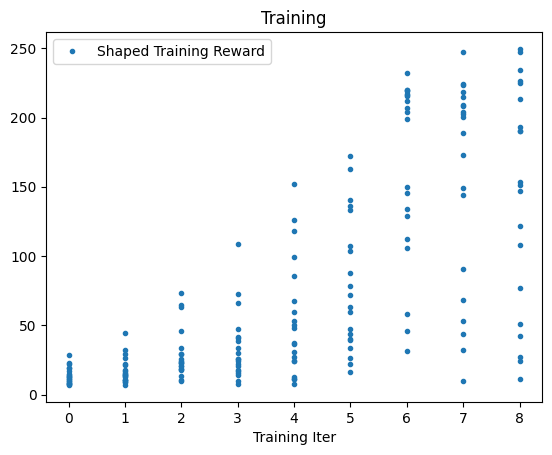

In [42]:
title = "Training"
df_csv.plot(x='Training Iter', y='Shaped Training Reward', style='.', 
        title=title)

<Axes: >

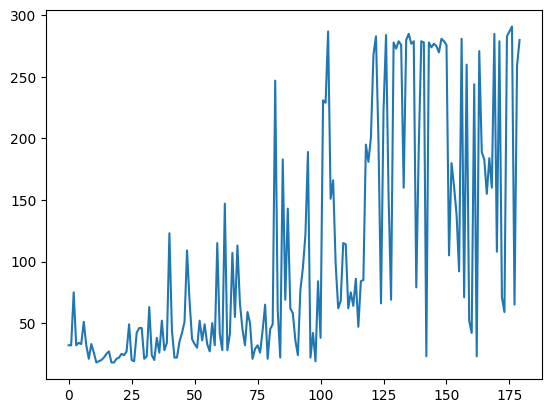

In [43]:
df_csv['Episode Length'].plot()

## What Is The Model "Looking" At?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

In [44]:
# Feed track images to the model and generate a heatmap showing which part of the track
# the model is paying the most attention to
import cv2

def visualize_gradcam_discrete_ppo(sess, rgb_img, category_index=0, num_of_actions=5):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x:[img_arr]}

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])
    
    # For front cameras use the below
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/{}/Conv2d_4/Conv2D:0'.format(sensor))
    
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / np.max(cam) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

In [45]:
#
# Locate model file(s)
# 
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

if download_from_aws:
    model_pb_path = models_file_path[0] # Change the index here to evaluate different model checkpoints
else:
    model_pb_path = './intermediate_checkpoint/deepracer-local/model-artifacts/agent/model.pb'

if download_from_aws:
    models_file_path = glob.glob("{}{}/model/model_*.pb".format(GRAPH_PB_PATH, ModelUuid))
else:
    models_file_path = [model_pb_path]

model, obs, model_out = load_session(model_pb_path)
heatmaps = []

# Match up the shape of the neural network
if 'action_space_type' in model_metadata and model_metadata['action_space_type']=='continuous':
    num_of_actions=2
else:
    num_of_actions=len(action_names)

# We use random.randint from numpy to choose 10 images at random from the full set
images = np.random.randint(len(all_files), size=10)
print(len(all_files))
print(images)

for i in images:
    f = all_files[i]
    img = np.array(Image.open(f))
    heatmap = visualize_gradcam_discrete_ppo(model, img, category_index=0, num_of_actions=num_of_actions)
    heatmaps.append(heatmap)
tf.reset_default_graph()

Device mapping: no known devices.
load graph: ./intermediate_checkpoint/deepracer-local/model-artifacts/agent/model.pb
Instructions for updating:
Use tf.gfile.GFile.
917
[796  23 429 441 657 473 396 622 861 787]


2024-05-15 10:49:50.537979: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-05-15 10:49:50.540770: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:50.540776: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:50.540779: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:50.540781: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:50.540785: I tensorflow/core/com

main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/BiasAdd: (BiasAdd): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/BatchnormActivationDropout_1_activation: (Relu): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_2/k

/var/folders/vf/s1p07xcn575483lt5dg2cjtc0000gr/T/ipykernel_96576/837129845.py:39: RuntimeWarning: invalid value encountered in divide
  heatmap = cam / np.max(cam) # normalize
/var/folders/vf/s1p07xcn575483lt5dg2cjtc0000gr/T/ipykernel_96576/837129845.py:40: RuntimeWarning: invalid value encountered in cast
  cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
2024-05-15 10:49:51.132047: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.132060: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.132063: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CP

ad_0/policy_mean/bias: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot/on_value: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot/off_value: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot/indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot/depth: (Const): /job:localhost/replica:0/task:0/device:CPU:0
strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:CPU:0
strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients/grad_ys_0/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients/Sum_grad/Reshape/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients/Sum_grad/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients/strided_slice_grad

2024-05-15 10:49:51.363820: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.363833: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.363836: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.363838: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.363845: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

/network_1/mul_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/mul_1_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/mul_1_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot_2/on_value: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot_2/off_value: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot_2/indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot_2/depth: (Const): /job:localhost/replica:0/task:0/device:CPU:0
strided_slice_2/stack: (Const): /job:localhost/replica:0/task:0/device:CPU:0
strided_slice_2/stack_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
strided_slice_2/stack_2: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Const_2: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/Shape: (Const): /job:localhost/replica

2024-05-15 10:49:51.616747: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.616760: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.616763: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.616765: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.616768: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

vice:CPU:0
gradients/strided_slice_grad/StridedSliceGrad/strides: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients/Mul_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients/Mul_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/begin: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/end: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/strides: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients/main_level/agent/main/online/network_1/mul_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients/main_level/agent/main/online/network_1/mul_grad/Sum/reduction_indices: (Const): /job:localhost/replica

2024-05-15 10:49:51.849137: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.849152: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.849154: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.849157: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:51.849159: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

ost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/begin: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/end: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/strides: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/mul_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/mul_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/mul_1_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/mul_1_grad/Sum/reduction_indices: (Const): /job:localhost

2024-05-15 10:49:52.225992: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.226005: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.226008: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.226011: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.226013: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

rad/end: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/strided_slice_1_grad/StridedSliceGrad/strides: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/Mul_1_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/Mul_1_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/begin: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/end: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/strides: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/mul_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online

2024-05-15 10:49:52.459155: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.459167: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.459170: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.459173: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.459175: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

ents_3/main_level/agent/main/online/network_1/mul_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_3/main_level/agent/main/online/network_1/mul_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_3/main_level/agent/main/online/network_1/mul_1_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_3/main_level/agent/main/online/network_1/mul_1_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot_4/on_value: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot_4/off_value: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot_4/indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot_4/depth: (Const): /job:localhost/replica:0/task:0/device:CPU:0
strided_slice_4/stack: (Const): /job:localhost/replica:0/task:0/device:CPU:0
strided_slice_4/stack_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
strided_slice_4/stack_2: (Const): /j

2024-05-15 10:49:52.725543: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.725557: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.725560: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.725562: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.725564: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

ain_level/agent/main/online/network_1/mul_1_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/mul_1_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot_3/on_value: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot_3/off_value: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot_3/indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
one_hot_3/depth: (Const): /job:localhost/replica:0/task:0/device:CPU:0
strided_slice_3/stack: (Const): /job:localhost/replica:0/task:0/device:CPU:0
strided_slice_3/stack_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
strided_slice_3/stack_2: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Const_3: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_3/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_3/grad_ys_0/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
grad

2024-05-15 10:49:52.988200: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.988213: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.988216: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.988218: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-05-15 10:49:52.988221: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

rad/strides: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/Mul_5_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/Mul_5_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/begin: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/end: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/strides: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/main_level/agent/main/online/network_1/mul_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/main_level/agent/main/online/network_1/mul_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/

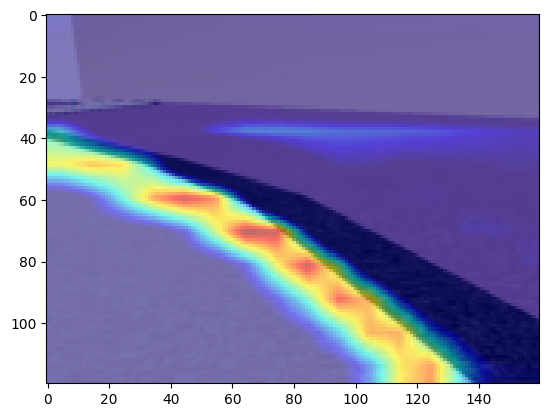

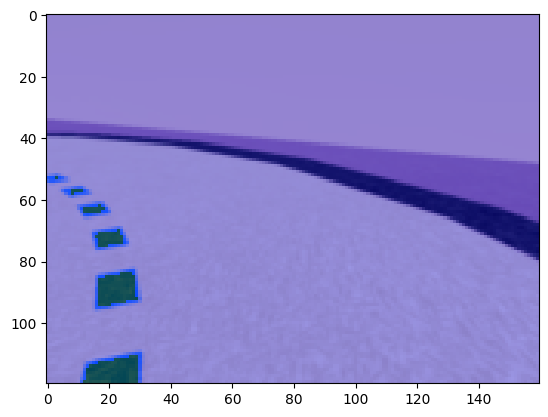

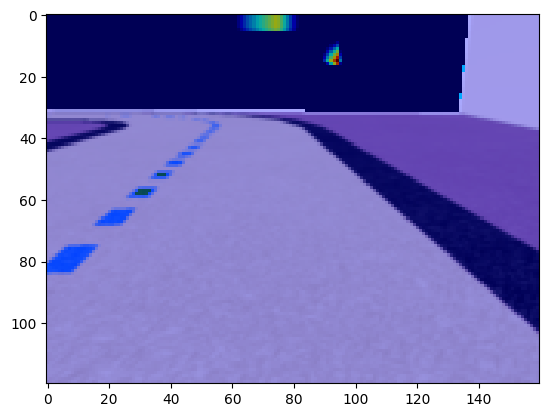

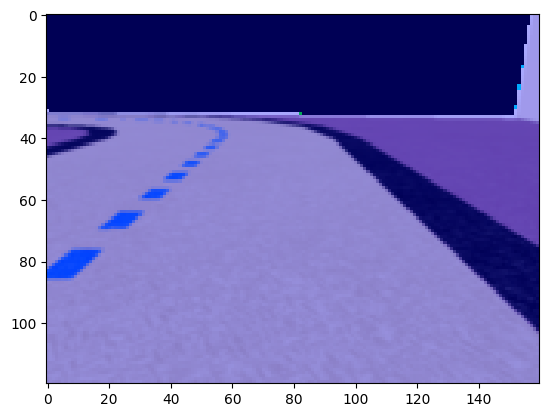

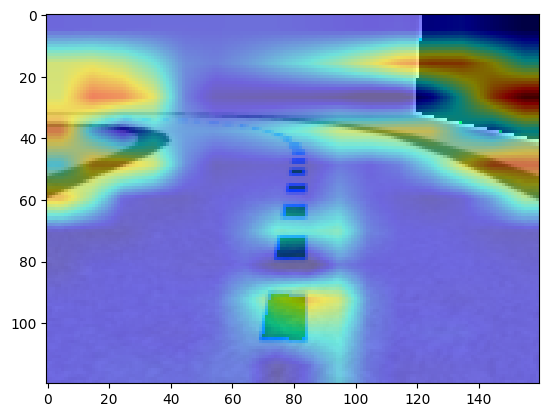

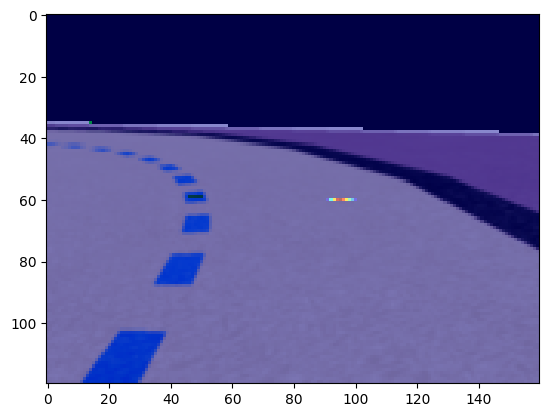

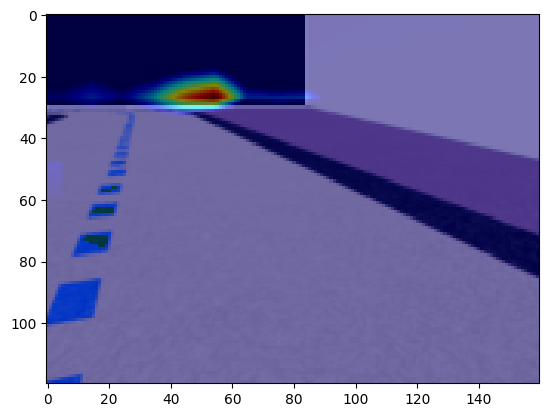

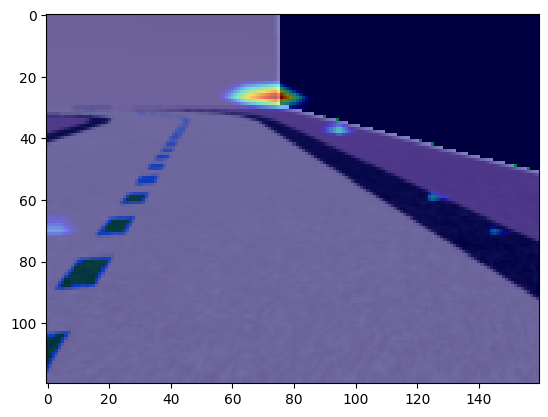

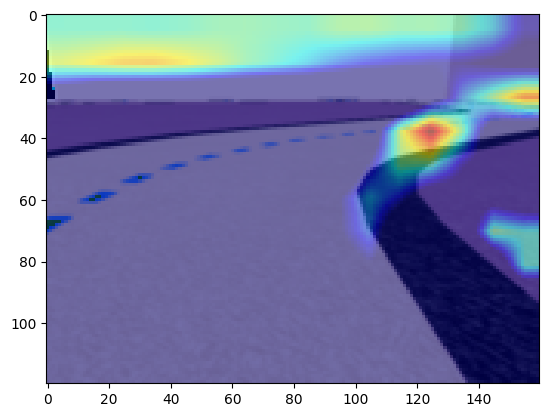

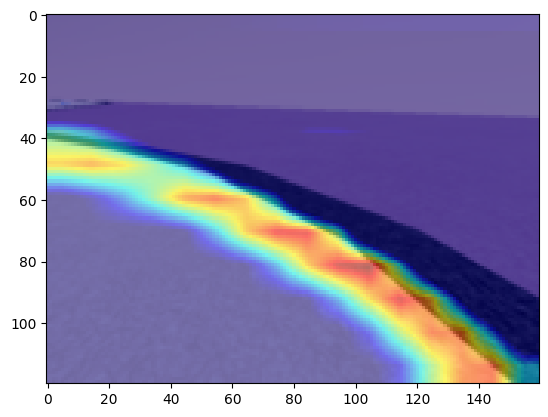

In [46]:
for i in range(len(heatmaps)):
    plt.imshow(heatmaps[i])
    plt.show()